<a href="https://colab.research.google.com/github/ribeiroenzo/PUC-MBA/blob/main/MVP_Sprint2_EnzoRibeiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint: Machine Learning & Analytics - Enzo Ribeiro

## Definição do problema

1. Qual é a descrição do problema?
2. Você tem premissas ou hipóteses sobre o problema? Quais?
3. Que restrições ou condições foram impostas para selecionar os dados?
4. Descreva o seu dataset (atributos, imagens, anotações, etc).

1. Esse MVP se baseia em dados do Mercado de Luxo de Cosméticos no Brasil. O dataset usado é o mesmo para o MVP de análise exploratória de dados, onde chegamos a conclusão que a categoria/canal que estão desacelerando o mercado de luxo é Men Fragrances na Department Store, por conta do seu aumento agressivo de preço no MVP1 (https://github.com/ribeiroenzo/PUC-MBA/blob/main/MVP_Sprint1_EnzoRibeiro.ipynb). Para esse MVP, o problema é entender a projeção do mercado de Luxo por canal/categoria no ano de 2024. Qual canal/categoria vão ter a maior evolução e quais vão desacelerar o mercado? Para isso, temos que entender qual modelo é o mais adequado para essa projeção.
2. Tenho hipótese de que a categoria que mais vai crescer é Make Up e o canal o Other B&M, tendo em vista que esse foi o comportamento qualitativo visto em 2023.
3. Esses dados possuem confidencialidade, logo foi necessário tirar colunas que possuiam um maior número de detalhe e manipular, antes da importação, os valores de venda, se retratando, então, de dados fictícios.
4.
*   'Channel': canal de vendas, pode ser físico (Department Stores ou Other B&M) ou Online
*   'Company': nome da empresa
*   'Category': categoria do produto de beleza (fragrâncias, maquiagem ou skincare)
*   'Subcategory': subcategoria com detalhes adicionais
*   'Year', 'Month': atributos referentes a data de venda
*   'U', '$': venda em unidades e valor (representado em reais)
       

## Preparação de Dados

* Separe o dataset entre treino e teste (e validação, se aplicável).
* Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.
* Verifique quais operações de transformação de dados (como normalização e padronização, transformação de imagens em tensores) são mais apropriadas para o seu problema e salve visões diferentes do seu dataset para posterior avaliação dos modelos.
* Refine a quantidade de atributos disponíveis, realizando o processo de feature selection de forma adequada.

### Importação e limpeza do dataset

In [406]:
# importação de bibliotecas
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import tensorflow as tf

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dropout, Dense, InputLayer, LSTM
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes # para importar o dataset diabetes
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM

Agora iremos importar o dataset com que iremos utilizar a partir do github, e armazenaremos os dados em um dataframe. Neste prática, trabalharemos com o dataset **Mercado**, um dos datasets mais utlizados no contexto profissional do autor. Alguns dados foram ocultos e os valores alterados para manter a confidencialidade.

In [407]:
mercado = pd.read_csv('https://raw.githubusercontent.com/ribeiroenzo/PUC-MBA/main/Base_Mercado2.csv',sep=';')

Inicialmente, iremos utilizar alguns comandos da biblioteca Pandas para exibir algumas estatísticas descritivas e fazer uma rápida análise exploratória do dataset. Os comentários nos blocos de código auxiliam no seu entendimento.

In [408]:
# verificando que mercado é um dataframe
type(mercado)

pandas.core.frame.DataFrame

In [409]:
mercado.head()

,Channel,Company,Category,Subcategory,Year,Month,U,$
0,B&M,Estée Lauder Brasil,Make Up,Mascaras,2022,Nov,28260,3023575
1,B&M,Other exclusives,Make Up,Blush,2023,Dec,20144,3125859
2,B&M,Other exclusives,Make Up,Blush,2023,Nov,17364,2529059
3,B&M,Other exclusives,Make Up,Foundations,2021,Nov,14385,1981918
4,Online,Other exclusives,Make Up,Blush,2023,Nov,14042,1868092


In [410]:
mercado.tail()

,Channel,Company,Category,Subcategory,Year,Month,U,$
35400,Online,Puig Brasil,Women fragrances,Perfumes and extract,2022,Dec,-1,-657
35401,Other B&M,TFS,Men fragrances,Aftershave,2023,Jul,-1,-198
35402,Online,Other Companies,Men fragrances,EDP/eau de parfum,2023,Jan,-1,-390
35403,Online,Puig Brasil,Men fragrances,Scented soaps,2021,Aug,-2,0
35404,Online,Other exclusives,Women fragrances,Other Juices,2023,Nov,-8,-1239


Um ponto que me chamou atenção ao visualizar o tail são as linhas com Unidades vendidas negativas. Como os dados são referentes a dados do mercado de Luxo, vamos limpar as linhas negativas que são outliers, pois elas podem influenciar na análise preditiva.

In [411]:
mercado = mercado[mercado.U > 0].copy()
mercado.tail()

,Channel,Company,Category,Subcategory,Year,Month,U,$
35390,Online,Niclos Comercial,Women fragrances,EDT/eau de toilette,2022,Feb,1,51
35391,Online,Niclos Comercial,Women fragrances,EDT/eau de toilette,2022,Mar,1,51
35392,Other B&M,Delfos,Men fragrances,EDT/eau de toilette,2021,Nov,1,136
35393,Other B&M,Delfos,Men fragrances,EDT/eau de toilette,2022,Feb,1,103
35394,Other B&M,Delfos,Men fragrances,EDT/eau de toilette,2022,Apr,1,103


Agora vamos verificar se temos linhas com valores em branco e fazer a limpeza.

In [412]:
# eliminando linhas que tenham TODOS os valores missing
mercado = mercado.dropna(how='all')

In [413]:
mercado_with_nulls = mercado.loc[mercado.isnull().any(axis=1)]
mercado_with_nulls

,Channel,Company,Category,Subcategory,Year,Month,U,$


Aqui podemos ver que não há nenhuma linha parcialmente vazia. Logo, não precisamos nos preocupar com missings na análise exploratória.

### Verificação das características

In [414]:
# verificando os tipos de cada coluna do dataframe
mercado.dtypes

Channel        object
Company        object
Category       object
Subcategory    object
Year            int64
Month          object
U               int64
$               int64
dtype: object

In [415]:
# exibindo as dimensões do dataset
mercado.shape

(35328, 8)

O Dataset analisado contém 35.328 linhas e 8 colunas. Entre essas colunas, existem 6 atributos ['Channel', 'Company', 'Category', 'Subcategory', 'Year', 'Month'] e 2 instâncias ['U', '$'].

In [416]:
# exibindo um sumário estatístico
mercado.describe()

,Year,U,$
count,35328.000000,35328.000000,3.532800e+04
mean,2021.986073,789.205474,2.455414e+05
std,0.816008,2704.014762,9.737471e+05
min,2021.000000,1.000000,-7.730000e+03
25%,2021.000000,11.000000,3.263000e+03
50%,2022.000000,59.000000,1.673650e+04
75%,2023.000000,392.000000,1.022030e+05
max,2023.000000,77619.000000,2.752925e+07


Com essa visão, é possível perceber que o DataSet contém dados desde 2019 até 2023 de vendas do mercado de Luxo. Além disso, nota-se que a menor venda de uma empresa em um mês de uma subcategoria é de 1 unidade e a maior é de 80.722 unidades.

### Análise inicial e adição de colunas

A fim de analisarmos os nossos dados de diversos ângulos, o Pandas permite reorganizarmos um dataframe, por exemplo, ordenando-o por alguma coluna. Também podemos selecionar uma ou mais colunas e/ou linha específicas, como mostram os exemplos a seguir. Os comentários nos blocos de código auxiliam no seu entendimento.

In [417]:
# ordenando o dataframe por uma coluna
mercado.sort_values(by='$', ascending=False)

,Channel,Company,Category,Subcategory,Year,Month,U,$
25779,Online,L'Oréal Brasil,Women fragrances,EDP/eau de parfum,2022,Nov,77619,27529250
25781,Online,L'Oréal Brasil,Women fragrances,EDP/eau de parfum,2023,Nov,65207,26601594
25833,Department Stores,Puig Brasil,Women fragrances,EDP/eau de parfum,2022,Dec,47894,23704412
25846,Department Stores,Puig Brasil,Women fragrances,EDP/eau de parfum,2023,Dec,44490,23091230
25815,Department Stores,Puig Brasil,Women fragrances,EDP/eau de parfum,2021,Dec,45565,20369032
...,...,...,...,...,...,...,...,...
22638,Online,Sisley,Skincare,BC others,2023,Mar,3,-289
24914,B&M,Sisley,Skincare,BC others,2023,Nov,1,-332
19390,Online,Prestige Cosmeticos,Skincare,Whitening/dark spots,2023,Jan,1,-391
23613,Online,Sisley,Make Up,Make Up Accessories,2022,Nov,2,-1223


Com essa visão acima, é possível concluir que historicamente os meses com maiores vendas para o mercado de beleza de Luxo são puxados pela categoria Women Fragrances. Além disso, observa-se que a L'Oréal é a empresa que mais vende em Novembro no canal Online e a Puig é a empresa que mais vende em Dezembro no canal de Dept. Stores.

Como vamos começar a excluir colunas para deixar apenas as informações necessárias para o treinamento do dataset, irei fazer uma cópia e chamá-lo de df.

In [418]:
df = mercado.copy()

Na tabela acima podemos notar algumas mudanças que devem ser feitas:
- O mês está por escrito, o que dificulta o treinamento do modelo;
- Não há uma coluna de Data;
- Como expliquei no início, só deveríamos ter 3 diferentes canais. Mas o dataset veio com 4 canais, com o canal "B&M" em alguns casos onde deveria ser "Other B&M";
- Além disso, vamos mudar o $ para Valor para facilitar a referência a essa variável.

In [419]:
# colocar os meses para números
df.Month = pd.to_datetime(df.Month, format='%b').dt.month

# criando coluna que será index de Data
df['Data'] = pd.to_datetime(df.Year.astype('str') + df.Month.astype('str') + '01', format='%Y%m%d')

df = df.rename(columns={'$':'Valor'})


In [420]:
df['Channel'] = df['Channel'].replace('B&M', 'Other B&M')

# Obter os valores únicos da coluna "Channel"
valores_unicos = df['Channel'].unique()

# Exibir os valores únicos
print(valores_unicos)

['Other B&M' 'Online' 'Department Stores']


In [421]:
df.head()

,Channel,Company,Category,Subcategory,Year,Month,U,Valor,Data
0,Other B&M,Estée Lauder Brasil,Make Up,Mascaras,2022,11,28260,3023575,2022-11-01
1,Other B&M,Other exclusives,Make Up,Blush,2023,12,20144,3125859,2023-12-01
2,Other B&M,Other exclusives,Make Up,Blush,2023,11,17364,2529059,2023-11-01
3,Other B&M,Other exclusives,Make Up,Foundations,2021,11,14385,1981918,2021-11-01
4,Online,Other exclusives,Make Up,Blush,2023,11,14042,1868092,2023-11-01


Com todas essas mudanças realizadas, vamos deixar no dataset apenas os atributos e variáveis relevantes para a análise preditiva do modelo. Como falamos, a projeção de vendas deve ser realizada a nível "Channel" e "Category", logo não precisamos das colunas "Company" e "Subcategory", que iriam aumentar a dificuldade da projeção.

Além disso, com a coluna de "Data", não é necessário ter a coluna "Year" e "Month".

Por fim, a projeção será apenas da variável "Valor", logo não precisamos da coluna "U" que se refere a venda em unidades.

In [422]:
# limpando a base pois não quero usar a coluna U
df = df.drop(columns=['Year', 'Month', 'U','Company','Subcategory'])

# agrupando os valores pois não sei se tem duplicatas
df = df.groupby(['Data', 'Channel','Category'], as_index=False).agg('sum')


Com os dados preparados e as limpezas realizadas, vamos plotar um gráfico com o overview por categoria/canal de 2023 para entendermos as particularidades de cada cenário.

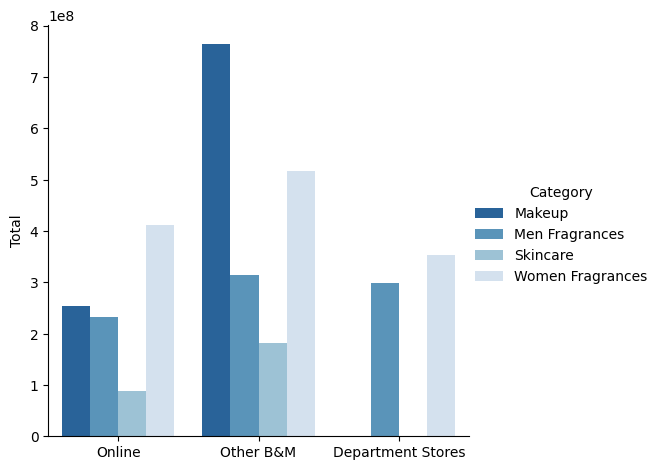

In [423]:
import seaborn as sns

soma_vendas = df[df['Data'].dt.year == 2023].groupby(['Category', 'Channel'])['Valor'].sum().reset_index()

#Total de Vendas Categoria por Canal
g = sns.catplot(x="Channel", y="Valor", kind="bar",hue = 'Category', palette="Blues_r", data=soma_vendas,legend_out= True)

# Eixos
(g.set_axis_labels("", "Total")
  .set_xticklabels(["Online", "Other B&M","Department Stores"])
  )

# Legenda
g._legend.set_title('Category')
new_labels = ['Makeup', 'Men Fragrances','Skincare','Women Fragrances']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

Com esse gráfico podemos ter alguns outputs importantes para continuarmos a análise.
- Apenas o Online e o Other B&M comercializam todas as categorias. Department Stores (Renner, Riachuelo e C&A) vendem apenas fragrâncias;
- O Other B&M é o canal que tem a maior concentração de vendas, seguido pelo Online e por último Department Stores;
- A Categoria mais vendida é Women Fragrances/Make Up, mas para tirarmos essa conclusão vamos ter que montar um gráfico/tabela com uma comparação mais clara.

In [424]:
soma_vendas_category = df[df['Data'].dt.year == 2023].groupby(['Category'])['Valor'].sum().reset_index()

print(soma_vendas_category)

           Category       Valor
0           Make Up  1017262675
1    Men fragrances   846772779
2          Skincare   269961623
3  Women fragrances  1282919552


In [425]:
soma_vendas_channel = df[df['Data'].dt.year == 2023].groupby(['Channel'])['Valor'].sum().reset_index()

print(soma_vendas_channel)

             Channel       Valor
0  Department Stores   652665160
1             Online   987363520
2          Other B&M  1776887949


Então de fato as conclusões do gráfico estavam corretas, o Canal com mais vendas em 2023 foi o Other B&M (que é composto por lojas físicias como Sephora e outras perfumarias) e a categoria com mais vendas é a de perfumes femininos.

### Separação Dataset

In [426]:
mercado = df.copy()
historico = df.copy()

Antes de separar o dataset entre treino e teste, temos que transformar os atributos categóricos em numéricos. Para isso, vamos utilizar o One Hot Encoding e transformar Channel e Category em diversas colunas binárias.

In [427]:
# one-hot encoding para transformar Channel e Category em variáveis binárias

oh= OneHotEncoder(sparse_output=False).set_output(transform='pandas')

one_hot_encoded=oh.fit_transform(mercado[['Channel', 'Category']])

mercado = pd.concat([mercado,one_hot_encoded],axis=1).drop(columns=['Channel', 'Category'])

mercado = mercado.set_index('Data')

mercado.head()

,Valor,Channel_Department Stores,Channel_Online,Channel_Other B&M,Category_Make Up,Category_Men fragrances,Category_Skincare,Category_Women fragrances
Data,,,,,,,,
2021-02-01,11142435,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-02-01,14628247,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-02-01,9648666,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2021-02-01,8037069,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2021-02-01,5527698,0.0,1.0,0.0,0.0,0.0,1.0,0.0


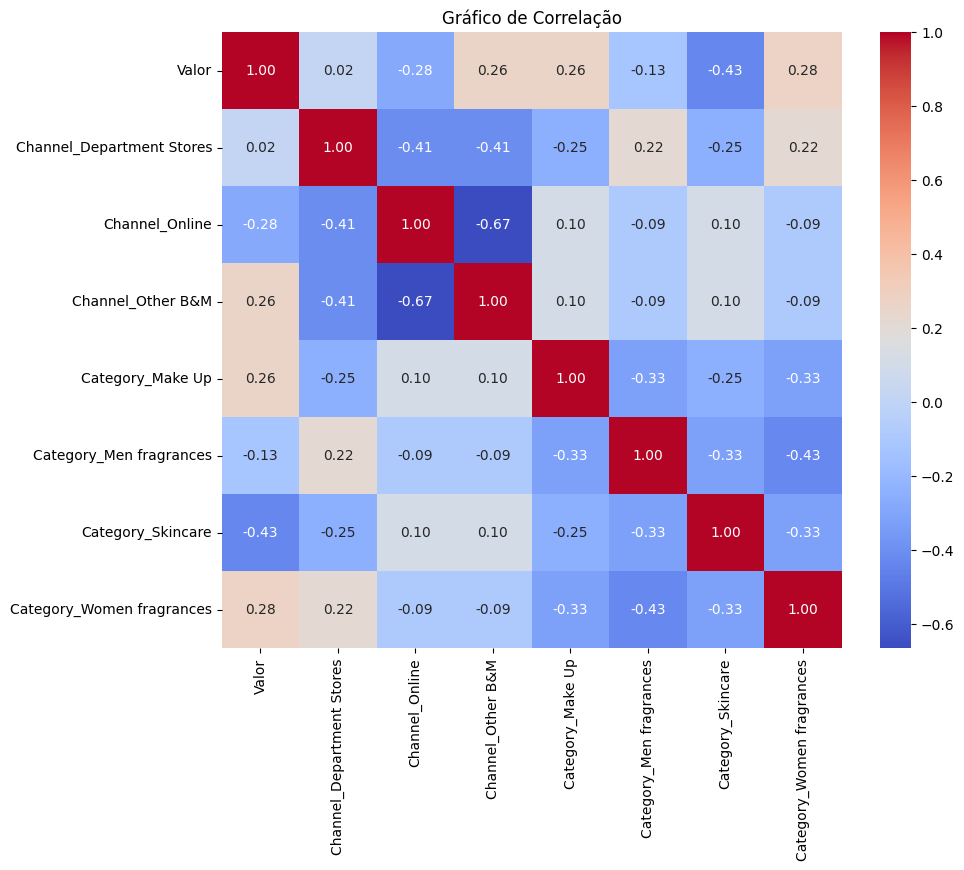

In [428]:
# Calcular a matriz de correlação
correlacao = mercado.corr()

# Criar o gráfico de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Gráfico de Correlação')
plt.show()

No gráfico de correlação, fica claro que não há uma correlação direta entre as variáveis. Entre as correlações mais "quentes" estão, como Make Up, Other B&M e Women Fragrances influenciam na variável Valor. Isso se dá porque o Other B&M é o maior canal de vendas e Women Fragrances e Make Up são as duas maiores categorias.

Além disso, o canal Department Stores também possui correlação com Women Fragrances e Men Fragrances já que essas são as unicas categorias comercializadas nesse canal.

Agora que apliquei o One Hot Encoder, irei separar o X e o Y e definir o conjunto de treino e teste, sendo 80% treino e 20% teste.

Por fim, separaremos em 10 folds, usando a validação cruzada.

In [438]:
# Escolhendo o nome das features
feature_names = list(mercado.columns)
feature_names.remove('Valor')

# Separar os atributos e a variavel target
X = mercado.drop('Valor', axis=1)
y = mercado['Valor']

# Separar o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

## Modelagem e Treinamento

* Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas.
* Há algum ajuste inicial para os hiperparâmetros?
* O modelo foi devidamente treinado? Foi observado problema de underfitting?
* É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.
* Há algum método avançado ou mais complexo que possa ser avaliado?
* Posso criar um comitê de modelos diferentes para o problema (ensembles)?


### Escolha do modelo mais adequado

LR: MSE 192186121705856.09 (75440136867267.12) - RMSE 13863120.92
Ridge: MSE 192208903316642.84 (77067009053102.36) - RMSE 13863942.56
Lasso: MSE 192333363221447.03 (76747339635837.25) - RMSE 13868430.45
KNN: MSE 199720707980672.28 (79648678561076.02) - RMSE 14132257.71
CART: MSE 159803632072341.84 (61137662476142.16) - RMSE 12641346.13
SVM: MSE 312943537451127.12 (119523657291064.00) - RMSE 17690210.22


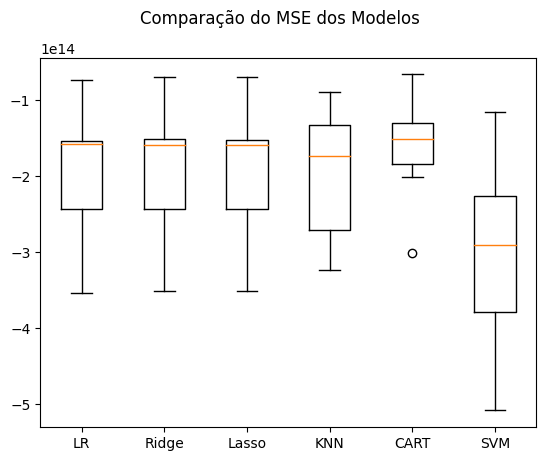

In [430]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

O MSE ainda ficou alto, vamos normalizar os dados de valor para entender a oportunidade de aumentar a acuracidade do modelo.

In [431]:
# Normalizando os dados de valor
scaler = MinMaxScaler(feature_range=(0, 1))
mercado['Valor'] = scaler.fit_transform(mercado[['Valor']])

In [432]:
# Set feature names explicitly
feature_names = list(mercado.columns)
feature_names.remove('Valor')

# Separate the features and the target
X = mercado.drop('Valor', axis=1)
y = mercado['Valor']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

LR: MSE 0.02 (0.01) - RMSE 0.13
Ridge: MSE 0.02 (0.01) - RMSE 0.13
Lasso: MSE 0.02 (0.01) - RMSE 0.15
KNN: MSE 0.02 (0.01) - RMSE 0.13
CART: MSE 0.01 (0.00) - RMSE 0.11
SVM: MSE 0.01 (0.01) - RMSE 0.12


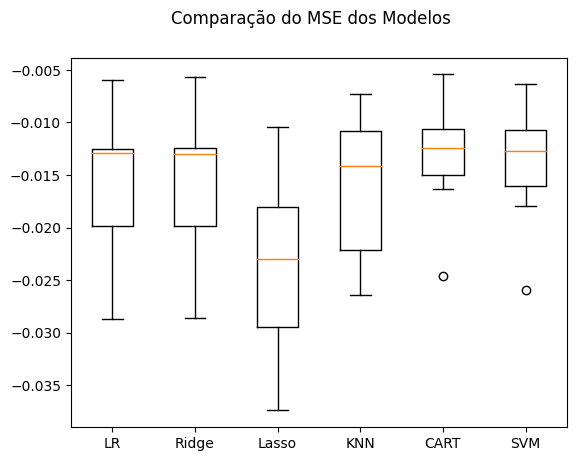

In [433]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliando um modelo por vez com validação cruzada
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Com a normalização, tivemos um aumento da acuracidade dos dados, vemos que faz sentido seguir com os dados normalizados. Como o CART apresentou o resultado mais próximo de 0, chegamos a conclusão que o algoritmo de árvore de decisão é o mais adequado para esse modelo. Logo é com ele que seguiremos para fazer as predições no conjunto de teste.

In [434]:
# Criando um modelo com todo o conjunto de treino com a Árvore de Decisão que foi o que obteve melhor resultado
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictions)
print("MSE %0.3f" % mse)
print("RMSE %0.3f" % np.sqrt(abs(mse)))

MSE 0.021
RMSE 0.145


In [435]:
# Otimização de hiperparâmetros (com GridSearch)
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[3, 5, 10], 'min_samples_split':[2, 5, 10]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)
model_cv.fit(X_train, y_train)

print(f'Melhores parâmetros: {model_cv.best_params_}')
print(f'Melhor score: {-model_cv.best_score_}')

Melhores parâmetros: {'max_depth': 5, 'min_samples_split': 2}
Melhor score: 0.013624117971665347


In [436]:
# Inicialize o modelo CART com os melhores parâmetros
model = DecisionTreeRegressor(random_state=42, max_depth=model_cv.best_params_['max_depth'], min_samples_split=model_cv.best_params_['min_samples_split'])

# Treine o modelo com os novos parâmetros
model.fit(X_train, y_train)

# Avalie o modelo novamente
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE %0.3f" % mse)
print("RMSE %0.3f" % np.sqrt(abs(mse)))

MSE 0.021
RMSE 0.145


Sendo assim, nota-se que não houve diminuição do RMSE com o ajuste dos hiper-parâmetros, logo esses não eram altamente relevantes para otimização do modelo.

Além disso, podemos verificar a importância das variáveis através da função feature_importances.

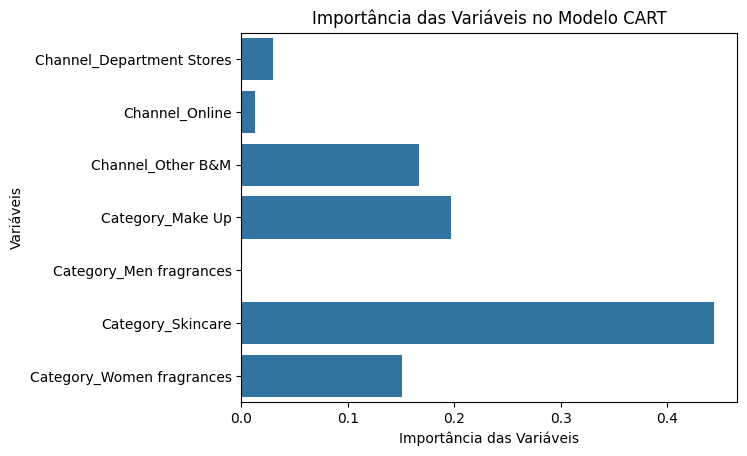

In [437]:
# Visualização da importância das variáveis
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Importância das Variáveis')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis no Modelo CART')
plt.show()

Curiosamente a variável com maior impacto no modelo CART foi a coluna do One Hot Encoder da Categoria Skincare, que possui valor binário. Provavelmente isso se dá porque essa categoria é a menor do mercado estudado e possui uma evolução menor do que as outras nos últimos anos, isso deve influenciar para que ela seja identificada como mais importante.

In [334]:
# Documentação do modelo no arquivo txt
with open('documentacao_modelo.txt', 'w') as f:
    f.write('Modelo CART para Análise do Mercado de Luxo\n')
    f.write(f'RMSE: {rmse}\n')
    f.write('Parâmetros do Modelo:\n')
    f.write(f'Max Depth: {model.get_params()["max_depth"]}\n')
    f.write(f'Min Samples Split: {model.get_params()["min_samples_split"]}\n')

In [335]:
#Previsões no conjunto de teste
y_pred = model.predict(X_test)

#Lista de valores preditos e valores reais
print("Valores preditos:", y_pred)

Valores preditos: [0.29811683 0.04132061 0.29811683 0.4328797  0.04132061 0.23314847
 0.04132061 0.23314847 0.4328797  0.29811683 0.30434926 0.29811683
 0.16368111 0.30434926 0.19076368 0.19009734 0.04132061 0.19009734
 0.14270222 0.19009734 0.30434926 0.14270222 0.29811683 0.4328797
 0.30434926 0.19076368 0.29811683 0.4328797  0.09456732 0.19009734
 0.14270222 0.19009734 0.19076368 0.14270222 0.14270222 0.19076368
 0.14270222 0.19009734 0.16368111 0.16368111 0.09456732 0.09456732
 0.4328797  0.23314847 0.23314847 0.30434926 0.14270222 0.29811683
 0.19076368 0.19009734 0.19076368 0.4328797  0.09456732 0.04132061
 0.19009734 0.19009734 0.30434926 0.04132061 0.19076368 0.16368111
 0.16368111 0.16368111 0.14270222 0.19076368 0.19076368 0.30434926]


In [336]:
print("Valores Reais:", y_test)

Valores Reais: Data
2021-02-01    0.107304
2022-07-01    0.028014
2022-04-01    0.236889
2021-06-01    0.220104
2021-11-01    0.111318
                ...   
2022-08-01    0.172000
2022-08-01    0.136971
2023-05-01    0.167357
2021-08-01    0.173458
2023-07-01    0.219410
Name: Valor, Length: 66, dtype: float64


Sendo assim, é possível concluir que entre os modelos aprendidos em aula, o mais aplicável para esse processo com o dataset mercado é o CART. Sendo assim, com a base de treino treinada e a base de teste prevista, o modelo de machine learning por árvore de regressão está pronto para ser utilizado.

Como aprendizados da disciplina, fica claro que, mesmo com todos os desafios no aprendizado dessa disciplina pela falta de contato prévio com python e machine learning, ela é altamente no ambiente de trabalho. Além disso, fica claro que não há um modelo e parâmetros únicos que devem ser seguidos em todos os casos, essa configuração varia entre cada dataset analisado.

### Predição através do Keras

A fim de tornar o projeto aplicável com uso de pacotes adicionais, realizei uma predição do Dataset para os próximos 12 meses utilizando o Keras. Sendo assim, como os dados do Dataset vão até dezembro de 2023, o código a seguir irá projetar o valor de vendas por canal e categoria até dezembro de 2024.

De início, vou definir o look back de 13 meses, que é o número de meses que o modelo vai olhar no passado para projetar o futuro.

Além disso, defini todas as combinações possíveis de Channel e Category, tendo em vista que nesse caso, não iremos atuar com o One Hot Encoder, mas sim fazer uma projeção para cada combinação e armanzenar a mesma em um Dataframe projections inicialmente vazio.

Por fim, vamos normalizar os valores de venda para aumentar a assertividade da projeção.

In [337]:
# Preparando o dataset para o Keras
look_back = 13
projections = pd.DataFrame()

# Obtendo combinações únicas de 'Channel' e 'Category'
combinations = df[['Channel', 'Category']].drop_duplicates()

# Normalizando os dados de valor
scaler = MinMaxScaler(feature_range=(0, 1))
df['Valor'] = scaler.fit_transform(df[['Valor']])

In [338]:
for index, row in combinations.iterrows():
    channel = row['Channel']
    category = row['Category']

    # Filtrando o dataset para a combinação atual de 'Channel' e 'Category'
    filtered_df = df[(df['Channel'] == channel) & (df['Category'] == category)]

    # Preparando os dados para o modelo
    data = filtered_df['Valor'].values
    data = data.reshape((-1, 1))

    # Certifique-se de que há dados suficientes para o look_back
    if len(data) >= look_back:
        # Preparando os dados de entrada e saída para o modelo
        X, y = [], []
        for i in range(look_back, len(data)):
            X.append(data[i-look_back:i, 0])
            y.append(data[i, 0])
        X, y = np.array(X), np.array(y)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # Definindo o modelo LSTM
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Treinando o modelo
        model.fit(X, y, epochs=50, batch_size=32, verbose=1)

        # Fazendo a projeção para os próximos 12 meses
        predictions = []
        current_batch = data[-look_back:]
        for i in range(12):
            current_pred = model.predict(current_batch.reshape((1, look_back, 1)))[0]
            predictions.append(current_pred)
            current_batch = np.roll(current_batch, -1)
            current_batch[-1] = current_pred

        # Desnormalizando as previsões
        predictions = scaler.inverse_transform(predictions)

        # Criando o índice de datas futuras para o forecast
        last_date = filtered_df['Data'].iloc[-1]
        future_dates = [last_date + pd.DateOffset(months=x) for x in range(1, 13)]

        # Criando um DataFrame temporário com a projeção para a combinação atual
        temp_df = pd.DataFrame({
            'Data': future_dates,
            'Channel': channel,
            'Category': category,
            'Valor': predictions.flatten()
        })

        # Adicionando as projeções ao DataFrame principal
        projections = pd.concat([projections, temp_df], ignore_index=True)
    else:
        print(f'Não há dados suficientes para a combinação de Channel: {channel} e Category: {category} para usar um look_back de 13 meses.')

# Salvando as projeções em um arquivo CSV
projections.to_csv('sales_projections.csv', index=False)

print("As projeções foram salvas no arquivo 'sales_projections.csv'.")

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.0596
Epoch 2/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0564
Epoch 3/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0534
Epoch 4/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0505
Epoch 5/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0478
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0452
Epoch 7/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0428
Epoch 8/50
1/1 [==============================] - 0s 15ms/step - loss: 0.0406
Epoch 9/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0384
Epoch 10/50
1/1 [==============================] - 0s 16ms/step - loss: 0.0364
Epoch 11/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0345
Epoch 12/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0326
Epoch 13/50
1/1 [==============================] - 0s 16ms/step

Com isso, todas as projeções foram salvas no dataset mercado_proj. Vamos ver se o formato está de acordo com o esperado e juntar esse dataset com o historico até dezembro de 2023. Vamos extrair uma visão para csv, caso sejá útil a manipulação via excel.

In [339]:
mercado_proj = pd.concat([historico, projections], ignore_index=True)
mercado_proj.to_csv('mercado.csv', index=False)

In [348]:
mercado_proj.head()

,Data,Channel,Category,Valor,Ano
0,2021-02-01,Department Stores,Men fragrances,11142435.0,2021
1,2021-02-01,Department Stores,Women fragrances,14628247.0,2021
2,2021-02-01,Online,Make Up,9648666.0,2021
3,2021-02-01,Online,Men fragrances,8037069.0,2021
4,2021-02-01,Online,Skincare,5527698.0,2021


In [355]:
# Extrair o ano da coluna 'Data'
mercado_proj['Ano'] = mercado_proj['Data'].dt.year

mercado_proj.head()

,Data,Channel,Category,Valor,Ano
0,2021-02-01,Department Stores,Men fragrances,11142435.0,2021
1,2021-02-01,Department Stores,Women fragrances,14628247.0,2021
2,2021-02-01,Online,Make Up,9648666.0,2021
3,2021-02-01,Online,Men fragrances,8037069.0,2021
4,2021-02-01,Online,Skincare,5527698.0,2021


Vamos criar alguns gráficos para ter os principais outputs dessa análise preditiva feita através do Sequential do Keras.

<ipython-input-363-e098099a0a5b>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  linha, = ax2.plot(variacao_percentual.index, variacao_percentual, 'r-o', label='Evolução vs Y-1',color='gray')  # Removido linestyle


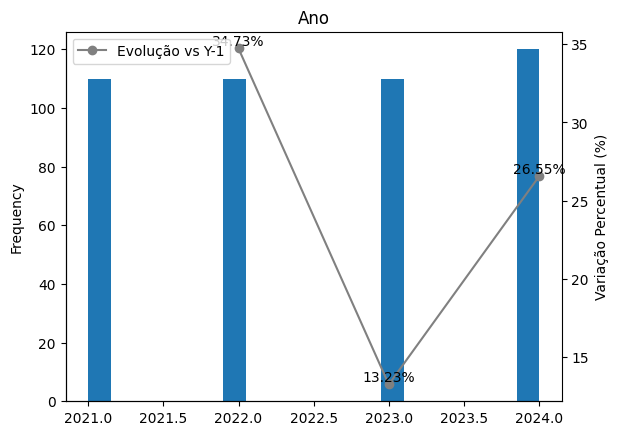

In [363]:
from matplotlib import pyplot as plt
# Calcular a soma dos valores por ano
soma_por_ano = mercado_proj.groupby('Ano')['Valor'].sum()

# Calcular a variação percentual ano a ano
variacao_percentual = soma_por_ano.pct_change() * 100

# Plotar o histograma dos anos
mercado_proj['Ano'].plot(kind='hist', bins=20, title='Ano')
plt.gca().spines[['top', 'right']].set_visible(False)

# Adicionar a linha de evolução versus Y-1
ax2 = plt.twinx()  # Cria um segundo eixo y
linha, = ax2.plot(variacao_percentual.index, variacao_percentual, 'r-o', label='Evolução vs Y-1',color='gray')  # Removido linestyle
ax2.set_ylabel('Variação Percentual (%)')
ax2.legend(loc='upper left')

# Adicionar rótulos de dados na linha de evolução
for ano, valor in variacao_percentual.items():
    ax2.text(ano, valor, f'{valor:.2f}%', ha='center', va='bottom')

plt.show()

A projeção aponta um crescimento de +26% para o mercado em 2024, que faz sentido tendo em vista que como em 2023 o mercado desacelerou, a contra-cifra do ano anterior é baixa. Vamos ver se esse comportamento se confirma com as tendências esperadas na abertura do trabalho.

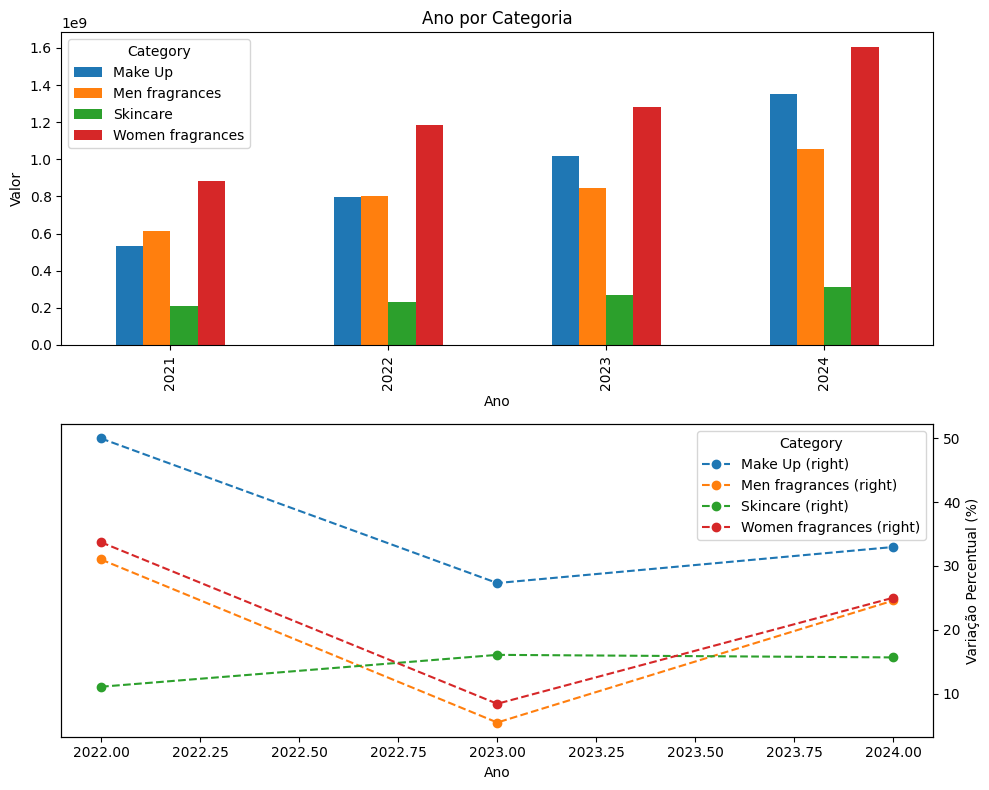

In [367]:
# Calculate the sum of values per year for each category
soma_por_ano_categoria = mercado_proj.groupby(['Ano', 'Category'])['Valor'].sum().unstack()

# Calculate the percentage variation year-over-year for each category
variacao_percentual_categoria = soma_por_ano_categoria.pct_change() * 100

# Calculate the sum of values per year for each channel
soma_por_ano_canal = mercado_proj.groupby(['Ano', 'Channel'])['Valor'].sum().unstack()

# Calculate the percentage variation year-over-year for each channel
variacao_percentual_canal = soma_por_ano_canal.pct_change() * 100

# Create a new figure object
fig = plt.figure(figsize=(10, 8))

# Plot the histogram of years by category
ax = fig.add_subplot(2, 1, 1)
soma_por_ano_categoria.plot(kind='bar', ax=ax, title='Ano por Categoria')
ax.set_ylabel('Valor')

# Plot the percentage variation by category
ax2 = fig.add_subplot(2, 1, 2)
variacao_percentual_categoria.plot(kind='line', ax=ax2, secondary_y=True, marker='o', linestyle='--')
ax2.right_ax.set_ylabel('Variação Percentual (%)')

plt.tight_layout()
plt.show()

Assim como esperado, a categoria que mais cresce é Make-Up, que tem acelerado muito nos últimos anos versus as outras categorias.

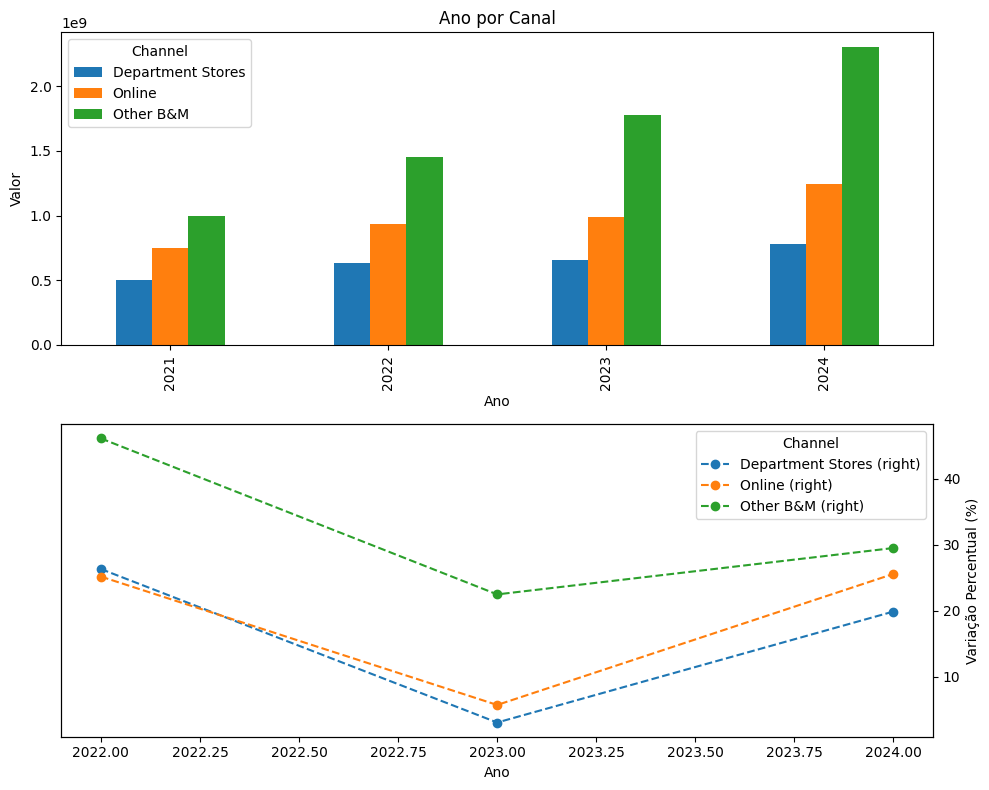

In [369]:
# Create a new figure object
fig = plt.figure(figsize=(10, 8))

# Plot the histogram of years by channel
ax = fig.add_subplot(2, 1, 1)
soma_por_ano_canal.plot(kind='bar', ax=ax, title='Ano por Canal')
ax.set_ylabel('Valor')

# Plot the percentage variation by channel
ax2 = fig.add_subplot(2, 1, 2)
variacao_percentual_canal.plot(kind='line', ax=ax2, secondary_y=True, marker='o', linestyle='--')
ax2.right_ax.set_ylabel('Variação Percentual (%)')

plt.tight_layout()
plt.show()

Assim como esperado, o canal que mais contribui para o crescimento do mercado é o Other B&M, canal que vimos no ínicio tem a categoria de Make-Up (a que mais cresce) com maior MIX dentro do canal.

Por fim, é nítido que toda a disciplina foi muito enriquecedora para o meu desenvolvimento profissional e acadêmico e que todas as projeções e análises realizadas estão em linha com os inputs conceituas esperados antes de iniciar o trabalho.